In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.InteractiveSession(config=config)
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display

C:\Users\umang\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\umang\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\umang\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\umang\Anaconda3\envs\tensorflow\lib\site-packages

In [2]:
import sys
import pathlib
sys.path.append(r'C:\Users\umang\Anaconda3\envs\tensorflow\intern_project\models\research')

In [3]:
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [4]:
# patch tf1 into `utils.ops`
utils_ops.tf = tf.compat.v1

# Patch the location of gfile
tf.gfile = tf.io.gfile

In [5]:
from object_detection import get_inference

Using TensorFlow backend.


In [6]:
MODEL_NAME = 'ssd_mobilenet_v1_coco_2018_01_28'
MODEL_FILE = MODEL_NAME + '.tar.gz'
PATH_TO_FROZEN_GRAPH ='models/research/object_detection/test_ckpt/'+MODEL_NAME+'/frozen_inference_graph.pb'
PATH_TO_LABELS = 'models/research/object_detection/data/mscoco_label_map.pbtxt'

In [7]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.compat.v1.GraphDef()
    with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

    sess = tf.compat.v1.Session(graph=detection_graph)

In [8]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [9]:
def load_image_into_numpy_array(image): 
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

In [10]:
PATH_TO_TEST_IMAGES_DIR = pathlib.Path('models/research/object_detection/test_images')
TEST_IMAGE_PATHS = sorted(list(PATH_TO_TEST_IMAGES_DIR.glob("*.jpg")))
TEST_IMAGE_PATHS
IMAGE_SIZE = (12,8)

In [11]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.compat.v1.Session() as sess:
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
        'num_detections', 'detection_boxes', 'detection_scores',
        'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)
      if 'detection_masks' in tensor_dict:
        #The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        real_num_detections = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1]) 
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1]) 
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[1], image.shape[2])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)

        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: image})
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.int64)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

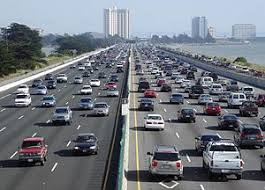

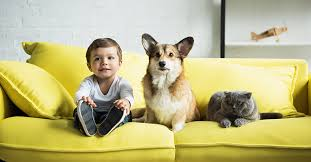

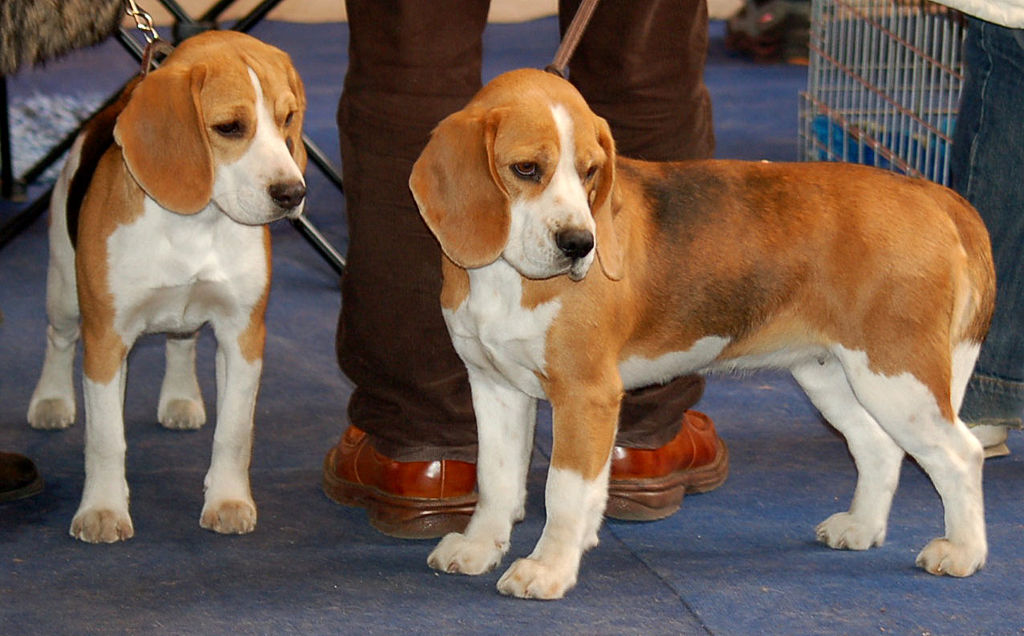

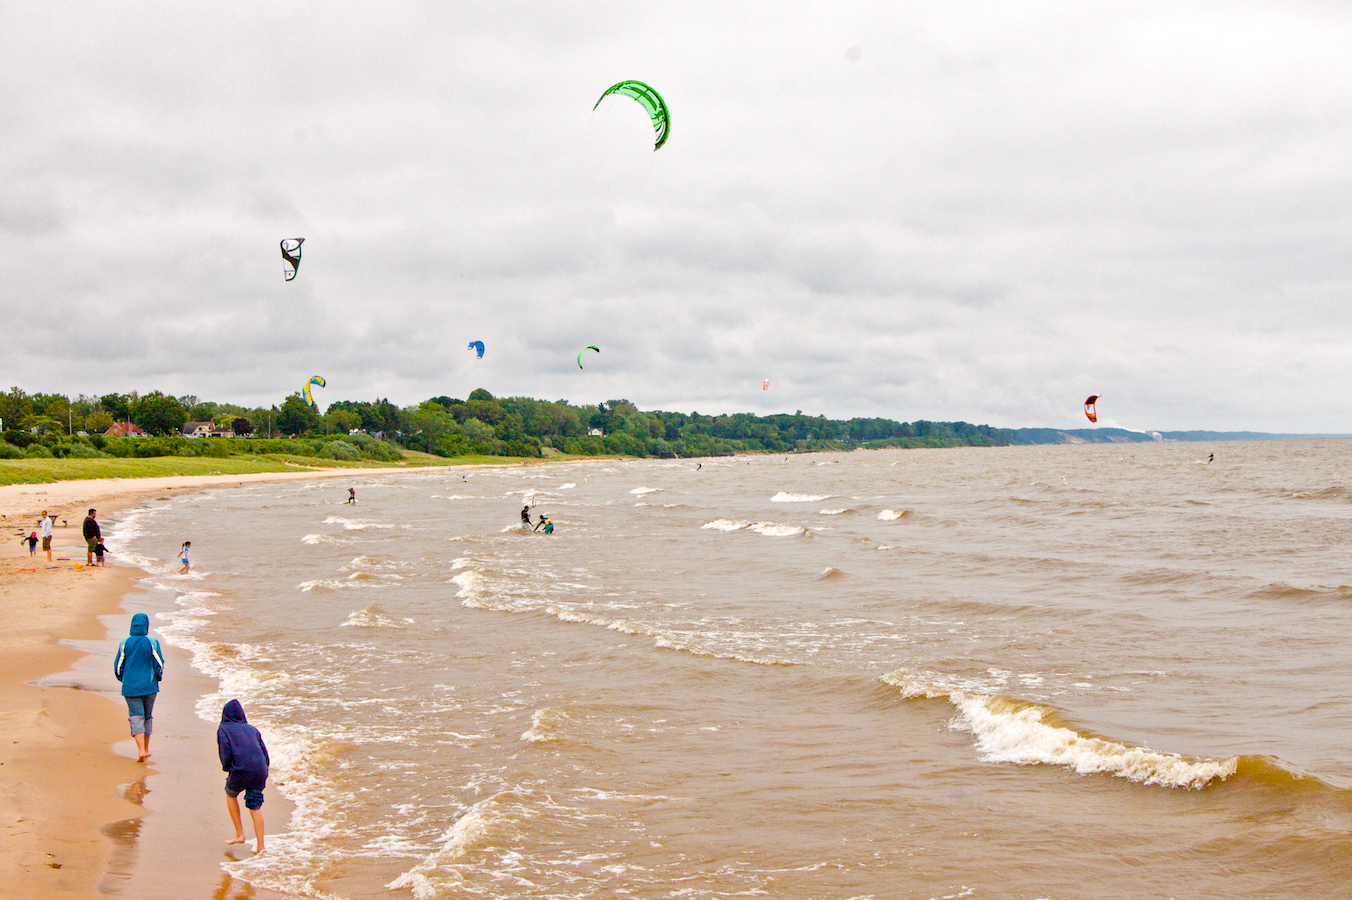

In [12]:
for image_path in TEST_IMAGE_PATHS: 
  image = Image.open(image_path)
  image_np = load_image_into_numpy_array(image) 
  display(Image.fromarray(image_np))

In [45]:
image_save_path = 'models/research/object_detection/annoted_images/mod_image'

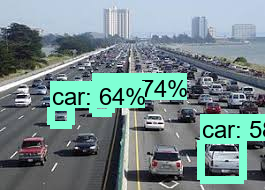

models\research\object_detection\test_images\download.jpg


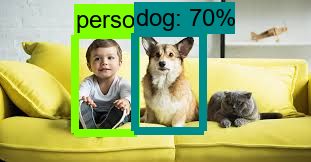

models\research\object_detection\test_images\hna.jpg


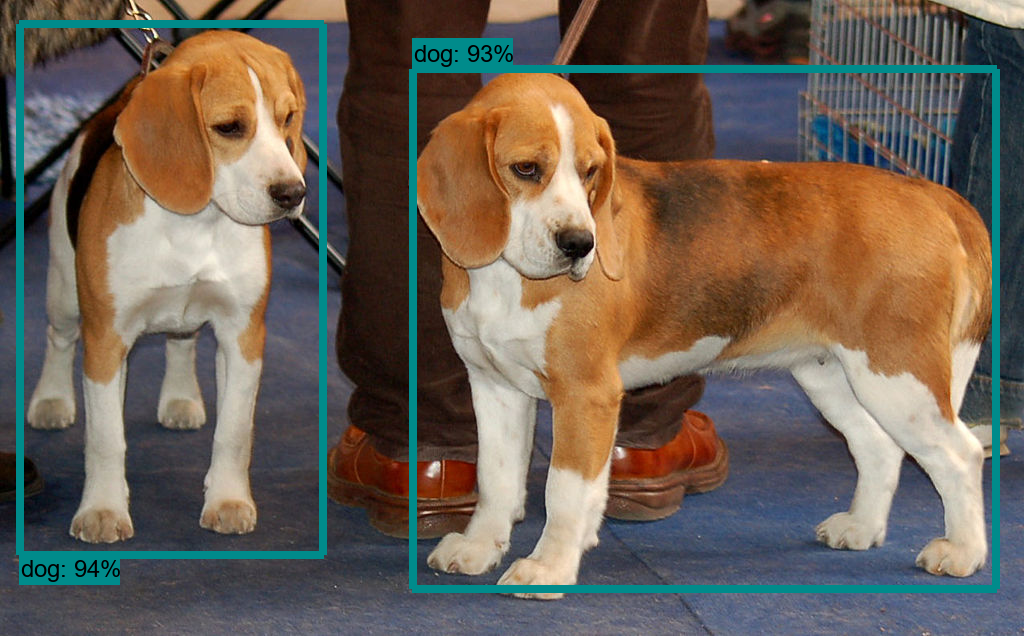

models\research\object_detection\test_images\image1.jpg


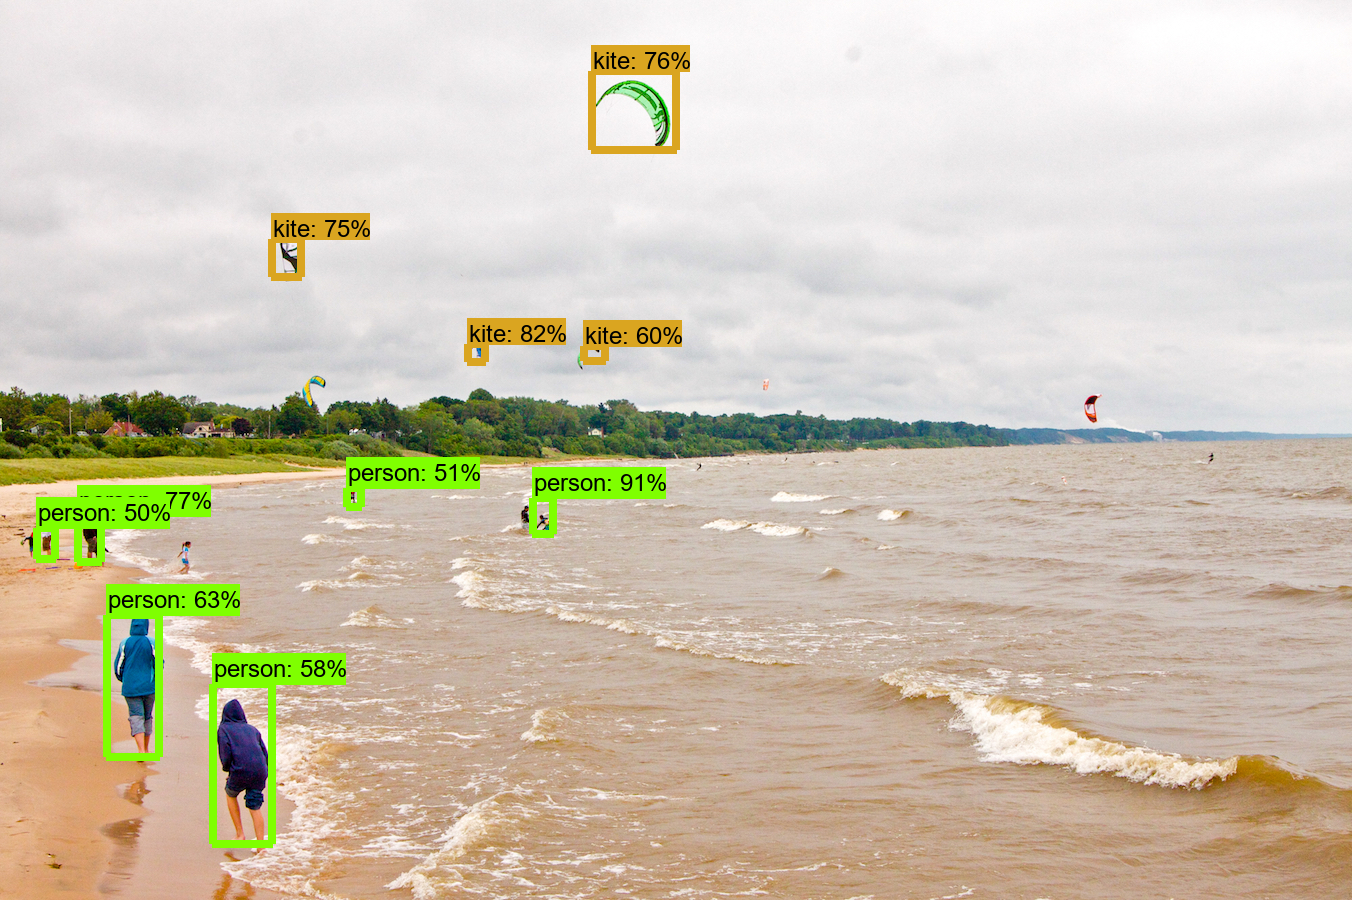

models\research\object_detection\test_images\image2.jpg


In [46]:
i = 0
for image_path in TEST_IMAGE_PATHS: 
  i = i+1
  image = Image.open(image_path)
  image_np = load_image_into_numpy_array(image) 
  image_np_expanded = np.expand_dims(image_np, axis=0)
  output_dict = run_inference_for_single_image(image_np_expanded, detection_graph)
  vis_util.visualize_boxes_and_labels_on_image_array(
    image_np,
    output_dict['detection_boxes'],
    output_dict['detection_classes'],
    output_dict['detection_scores'],
    category_index,
    instance_masks=output_dict.get('detection_masks'),
    use_normalized_coordinates=True,
    line_thickness=8)
  display(Image.fromarray(image_np))
  image_mod = Image.fromarray(image_np)
  image_mod.save(image_save_path+str(i)+'.jpg')
  print(image_path)

In [14]:
for image_path in TEST_IMAGE_PATHS:
  thresh = float(input())  
  get_inference.get_thresh(thresh)
  print(get_inference.get_roi_label(np.array(Image.open(image_path))))

0.5
([[135, 154, 62, 99, 78.57329845428467], [138, 178, 201, 243, 76.75419449806213], [106, 124, 52, 71, 64.65948820114136], [105, 121, 176, 196, 61.56388521194458], [32, 178, 2, 265, 54.54152822494507], [115, 127, 214, 238, 52.094000577926636], [122, 146, 236, 264, 51.9507110118866], [97, 110, 135, 153, 51.489681005477905]], ['car', 'car', 'car', 'car', 'car', 'car', 'car', 'car'])
0.7
([[32, 132, 136, 199, 89.56259489059448], [35, 136, 70, 138, 80.97490072250366]], ['dog', 'person'])
0.9
([[71, 596, 395, 1016, 95.58108448982239], [20, 531, 1, 323, 92.09074974060059]], ['dog', 'dog'])
0.9
([[509, 531, 527, 553, 94.32754516601562], [511, 556, 79, 102, 90.59385061264038]], ['person', 'person'])
